# CAISO Energy Storage Optimal Bid Generation

<b>Authors:</b> Nik Zheng, Neal Ma

<b>Date Created:</b> October 29, 2024

<b>Description:</b> This notebook generation optimal energy storage bid data from historical price data.

Optimal bid generation code based off: https://github.com/niklauskun/ES_NN_Arbitrage/blob/main/Energy-Storage-MLP/Energy_Storage_Arbitrage.ipynb

TODO: Label everything and fill in function definitions

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import time

## Read and Preprocess Data

In [9]:
# read energy storage data
ES_BIDS_df = pd.read_parquet("./data/ES_BIDS/CAISO_ES_BIDS.parquet")

# read real-time price data
RTP_df = pd.read_csv("./data/CAISO_RTP.csv")
RTP_df["Date"] = pd.to_datetime(RTP_df["Date"], format="%m/%d/%Y %I:%M:%S %p")
RTP_df = RTP_df.drop_duplicates(subset=["Date", "hub"])
RTP_df = RTP_df.pivot(index="Date", columns="hub", values="price")

# read day ahead price data
DAP_df = pd.read_csv("./data/CAISO_DAP.csv")
DAP_df["Date"] = pd.to_datetime(DAP_df["Date"], format="%m/%d/%Y %I:%M:%S %p")
DAP_df = DAP_df.drop_duplicates(subset=["Date", "zone"])
DAP_df = DAP_df.pivot(index="Date", columns="zone", values="price")

# merge dataframes
full_price_df = ES_BIDS_df.join(RTP_df, how="outer")
full_price_df = full_price_df.join(DAP_df, how="outer")

# filter for data between July 1, 2023 and October 1, 2024
full_price_df = full_price_df[
    (full_price_df.index >= pd.Timestamp("July 1, 2023"))
    & (full_price_df.index <= pd.Timestamp("October 1, 2024"))
]

hubs = ["TH_NP15", "TH_SP15", "TH_ZP26"]
zones = ["PGAE", "SCE", "SDGE", "VEA"]

# track min, max, avg real-time prices for all timestamps
full_price_df["rt_price_max"] = full_price_df[hubs].max(axis=1)
full_price_df["rt_price_min"] = full_price_df[hubs].min(axis=1)
full_price_df["rt_price_avg"] = full_price_df[hubs].mean(axis=1)

# track min, max, avg day-ahead prices for all timestamps
full_price_df["da_price_max"] = full_price_df[zones].max(axis=1)
full_price_df["da_price_min"] = full_price_df[zones].min(axis=1)
full_price_df["da_price_avg"] = full_price_df[zones].mean(axis=1)

# extract real-time price (forward fill NaNs)
RTP = full_price_df["rt_price_avg"].ffill().to_numpy()

# subselect ES bids to the time frame
ES_selected = ES_BIDS_df.loc[full_price_df.index]

## Define Simulation Functions

In [10]:
# Compute current value function using the value function from the next time period
def CalcValueNoUnc(d, c, P, eta, vi, ed, iC, iD):
    """
    Calculate Risk-Neutral value function using deterministic price

    :param d: current price
    :param c: marignal discharge cost
    :param p: power rating with respect to energy rating and sampling time (i.e. 2hr duration battery w/ 5 min resolution: P = (1/2)/12)
    :param eta: efficiency
    :param vi: input value function for the next time period, which equals v_t(e) where e is sampled from 0 to 1 at granularity e
    :param ed: granularity at which vi is sample, in p.u. to energy rating
    :return: value function (vo) for the current time period sampled at ed
    """
    # add a large number of upper and lower v, where the first point is
    # v_t(0-) = +infty, and the second point is v_t(0), the second largest one is
    # v_t(1), and the largest one is v_t(1+) = -infty
    lNum = 1e5 * np.ones((1,))
    v_foo = np.concatenate([lNum, vi, -lNum], axis=0)

    # # calculate soc after charge vC = v_t(e+P*eta)
    vC = v_foo[iC]

    # # calculate soc after discharge vC = v_t(e-P/eta)
    vD = v_foo[iD]

    # calculate CDF and PDF
    FtEC = (vi * eta > d).astype(int)  # F_t(v_t(e)*eta)
    FtCC = (vC * eta > d).astype(int)  # F_t(v_t(e+P*eta)*eta)
    FtED = ((vi / eta + c) * ((vi / eta + c) > 0) > d).astype(
        int
    )  # F_t(v_t(e)/eta + c)
    FtDD = ((vD / eta + c) * ((vD / eta + c) > 0) > d).astype(
        int
    )  # F_t(v_t(e-P/eta)/eta + c)

    # calculate terms
    Term1 = vC * FtCC
    Term2 = d * (vC * eta <= d) * (vi * eta > d) / eta
    Term3 = vi * (FtED - FtEC)
    Term4 = (
        d
        * (((vi / eta + c) * ((vi / eta + c) > 0)) <= d)
        * (((vD / eta + c) * ((vD / eta + c) > 0)) > d)
        * eta
    )
    Term5 = -c * eta * (FtDD - FtED)
    Term6 = vD * (1 - FtDD)

    # output new value function samped at ed
    vo = Term1 + Term2 + Term3 + Term4 + Term5 + Term6
    return vo

In [11]:
def ArbValue(lmp, v, e, P, E, eta, c, N):
    """
    Arbitrage test using value function

    :param lmp: lambda (electricity price over time period t)
    :param v: price function
    :param e: SoC
    :param P: actual power rating taking time step size into account (Pr * Ts)
    :param E: 1
    :param eta: efficiency
    :param c: marginal discharge cost
    :param N: number of SoC samples
    :return: #TODO
    """

    iE = np.ceil((N - 1) * e / E).astype(
        int
    )  # find the nearest SoC index. iE here is 1 smaller than MATLAB.

    vF = v.copy()  # read the value function
    # charge efficiency: iE+1 to end in Matlab, so iE to end here
    vF[iE + 1 :] = vF[iE + 1 :] * eta
    # discharge efficiency: 1 to iE-1 in Matlab, so 0 to iE-1 (exclusive) here
    vF[0:iE] = vF[0:iE] / eta + c

    # charge index
    if len(np.nonzero(vF >= lmp)[0]) > 0:
        iC = np.max(np.nonzero(vF >= lmp))
    else:
        iC = None

    # discharge index
    if len(np.nonzero(vF <= lmp)[0]) > 0:
        iD = np.min(np.nonzero(vF <= lmp))
    else:
        iD = None

    # iF = iC*(iC > iE) + iD*(iD < iE) + iE*(iC <= iE)*(iD >= iE);
    if iC is not None:
        if iC > iE:
            iF = iC
        elif iD is not None:
            if iD < iE:
                iF = iD
            else:
                iF = iE
        else:
            iF = iE
    elif iD is not None:
        if iD < iE:
            iF = iD
        else:
            iF = iE
    else:
        iF = iE

    eF = (iF) / (N - 1) * E
    eF = max(min(eF, e + P * eta), e - P / eta)
    pF = (e - eF) / eta * ((e - eF) < 0) + (e - eF) * eta * ((e - eF) > 0)

    return eF, pF

In [12]:
def generate_value_function(P, eta, c, ed, ef, Ne, T, num_segment, RTP):
    """
    Generate value function v and dowmsampled value function vAvg
    :param P:
    :param eta:
    :param c:
    :param ed:
    :param ef:
    :param Ne:
    :param T:
    :param num_segment:
    :param RTP: real-time price
    """

    start_time = time.time()

    # Set final SoC level
    vEnd = np.zeros(Ne)
    vEnd[0 : math.floor(ef * 1001)] = (
        1e2  # Use 100 as the penalty for final discharge level
    )

    # Define the risk-neutral value function and populate the final column.
    # v[0, 0] is the marginal value of 0% SoC at the beginning of day 1, v[Ne, T]is the maringal value of 100% SoC at the beginning of the last operating day
    v = np.zeros((Ne, T + 1))  # initialize the value function series
    v[:, -1] = vEnd  # v.shape == (1001, 210241)

    # Process indices: discretize vt by modeling it as an vector v_{t,j} in which each element is associated with equally spaced SoC samples
    es = np.arange(start=0, stop=1 + ed, step=ed)

    # the number of samples is J = 1 + E/ed
    Ne = len(es)

    # Calculate soc after charge vC = v_t(e+P*eta)
    eC = es + P * eta  # [0.0375 0.0385 0.0395 ... 1.0355 1.0365 1.0375]
    iC = np.ceil(eC / ed)
    iC[iC > (Ne + 1)] = Ne + 1
    iC[iC < 1] = 0

    # Calculate soc after discharge vC = v_t(e-P/eta)
    eD = es - P / eta
    iD = np.floor(eD / ed)
    iD[iD > (Ne + 1)] = Ne + 1
    iD[iD < 1] = 0

    # Populate value function
    for t in reversed(range(0, T)):  # start from the last day and move backwards
        vi = v[:, t + 1]  # input value function of next time stamp
        vo = CalcValueNoUnc(RTP[t], c, P, eta, vi, ed, iC.astype(int), iD.astype(int))
        v[:, t] = vo  # record the result

    end_time = time.time()
    print("Time:", end_time - start_time)

    # Downsample: https://stackoverflow.com/questions/14916545/numpy-rebinning-a-2d-array
    vAvg = (
        v[0:1000, :]
        .reshape([num_segment, int(1000 / num_segment), v.shape[1], 1])
        .mean(3)
        .mean(1)
    )

    return v, vAvg

## Generate Optimal Charge and Discharge Bids

In [13]:
# Set parameters
Ts = 1.0 / 12  # timestep in hours (5 minutes)
T = len(RTP)  # number of time steps
Pr = (
    1 / 3.5
)  # normalized power rating with respect to energy rating (highest power input allowed to flow through particular equipment)
P = Pr * Ts  # actual power rating taking timestep size into account
eta = 0.9  # efficiency
c = 30  # marginal discharge cost - degredation
ed = 0.001  # SoC sample granularity
ef = 0.5  # final SoC target level, use 0 if none
Ne = math.floor(1 / ed) + 1  # number of SoC samples (1/0.001) + 1 = 1001
e0 = 0.5  # initial SoC level

num_segment = 50  # downsample setting

In [16]:
# Marginal Opportunity Value Function Calculation
v, vAvg = generate_value_function(P, eta, c, ed, ef, Ne, T, num_segment, RTP)
print(v.shape)

Time: 10.893051862716675
(1001, 131906)


In [17]:
# Calculate SoC based on CAISO energy storage report duration (linear interpolation used for NaNs)
ES_selected["tot_charge_rtpd_adjusted"] = ES_selected.apply(
    lambda row: (
        row["tot_charge_rtpd"] / 30000.0
        if row.name.year == 2023
        else row["tot_charge_rtpd"] / 33250
    ),
    axis=1,
)
ES_selected["tot_charge_rtpd_adjusted"] = ES_selected[
    "tot_charge_rtpd_adjusted"
].interpolate(method="linear")

In [18]:
# Get segment number based on SoC at each timestamp
ES_selected["rtpd_soc"] = (
    (ES_selected["tot_charge_rtpd_adjusted"] * 1000.0 + 1).round().astype(int)
)

In [20]:
# Select opportunity value based on total SoC
selected_v_values = np.array(
    [v[soc - 1, idx] for idx, soc in enumerate(ES_selected["rtpd_soc"])]
)

In [21]:
# Optimal charge and discharge bids
optimal_charge_bids = selected_v_values * eta
optimal_discharge_bids = selected_v_values / eta + c

In [23]:
print(len(optimal_charge_bids), len(optimal_discharge_bids))
# TODO: Either calculate rolling window heere or in the next notebook...

131905 131905


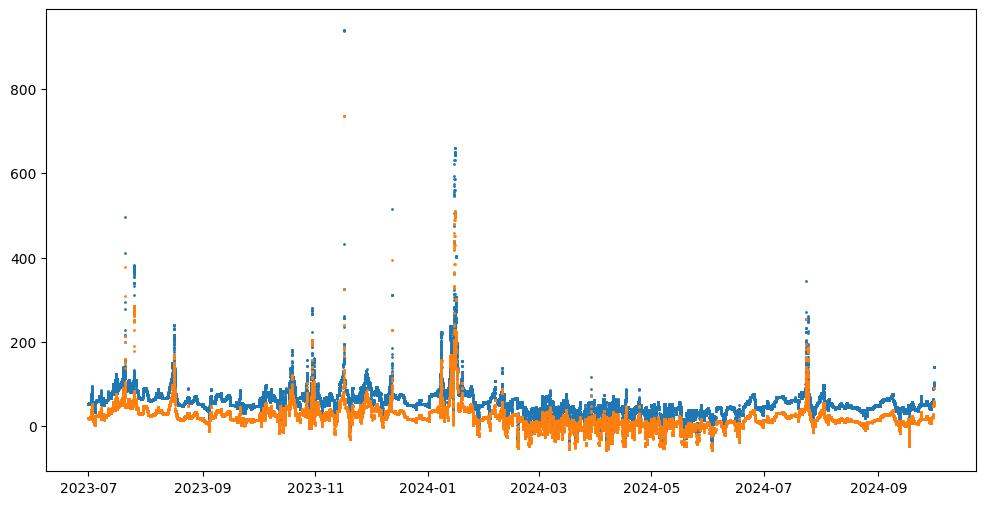

In [30]:
plt.figure(figsize=(12, 6))
plt.scatter(ES_selected.index, optimal_discharge_bids, s=1)
plt.scatter(ES_selected.index, optimal_charge_bids, s=1)

In [36]:
ES_optimal = pd.DataFrame(
    index=ES_selected.index,
    columns=["optimal_charge", "optimal_discharge"],
    data=np.array([optimal_charge_bids, optimal_discharge_bids]).T,
)
ES_optimal.to_csv("./data/optimal_bids.csv")